In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space

import os
cwd = os.getcwd()

In [5]:
def n_state_ABM(delta_t, T, V, Lambda, P, sigma, x0=0.0, t0=0.0, state='?', seed=1223):
    """
    Simulates axonal transport
    delta_t = time step (s) 8nm / 800nm/s = 0.01s
    T = total time (s)
    
    #all velocities (with sign)   
    V = [v_1, v_2, ..., v_n] # here indexed 0,1,...,n-1
    
    # rates time spent on state i
    Lambda = [lambda_1, lambda_2, ..., lambda_n] = (lambda_i) # here indexed 0,1,...,n-1
    
    # transition matrix: p_ij probability of switching from i to j
    P = (p_ij)            
    
    sigma #noise std
    
    x0 = initial position
    state = initial state known or '?'
    seed = select random seed
    """
    # set a random seed
    np.random.seed(seed)
    random.seed(seed)
    
    if delta_t<=0 or T<delta_t:
        print('Error defining time')
        return None
    
    n = Lambda.shape[0]
    
    if np.any(Lambda <= np.zeros(n)):
        print('Error defining lambdas')
        return None
    
    if n!=P.shape[0] or n!=P.shape[1] or n!=V.shape[0]:
        print('Error with dimensions')
        return None
    
    if np.any(np.diag(P) != np.zeros(n)):
        print('Error defining transition matrix P diag')
        return None
        
    if np.any(np.sum(P, axis=1) != np.ones(n)):
        print('Error defining transition matrix P sum')
        return None
    
    if np.any(sigma < 0):
        print('Error defining noise parameter sigma')
        return None
        
    t = [t0]
    x = [x0]
    curr_dt = 0
    curr_dx = 0

    #Building Q transpose
    Q = np.zeros((n,n))
    for i in range(n):
        for j in range(0,i):
            Q[i,j] = Lambda[i]*P[i,j]
        Q[i,i] = -Lambda[i]
        for j in range(i+1,n):
            Q[i,j] = Lambda[i]*P[i,j]
    Qt = Q.T
    
    #Computing w s.t. Q^T w = 0 and then P(st)
    W = null_space(Qt)
    P_st = W / np.sum(W)
    
    #Choosing an initial state
    if state=='?': #state -1 is unknown
        state = random.choices(np.arange(n), weights=P_st, k=1)[0]
        
    state_save = []
        
    while t[-1]<T: # T is in seconds again
        curr_dt = np.random.exponential(scale=1/Lambda[state])
        curr_dx = curr_dt*V[state]
        t.append(t[-1]+curr_dt)
        x.append(x[-1]+curr_dx)
        state_save.append(state)
        state = random.choices(np.arange(n), weights=P[state, :], k=1)[0]
    
    state_save.append(state)
    
    #CREATE delta_t=0.3 approx
    t_points = np.linspace(0, T, int(T/delta_t)+1) #e.g. 0, 0.3, 0.6, ..., 60
    #print(x,t)
    # generate error points
    x_points = np.zeros(t_points.shape)
    y_points = np.random.normal(loc=0, scale=sigma,
                                size=t_points.shape)
    switches = np.zeros(t_points.shape)
    state_it = state_save[0]
    all_states_save = [[] for i in range(int(T/delta_t)+1)]
    tauF_save = []
    tauB_save = []
    tauS_save = []
    
    j = 0
    p = np.polyfit(t[j:j+2], x[j:j+2], 1)
    for i in range(0,int(T/delta_t)+1):
        todo = True
        while todo:
            all_states_save[i].append(state_save[j])
            if t_points[i]>=t[j] and t_points[i]<=t[j+1]:
                x_points[i] += np.polyval(p, t_points[i])
                y_points[i] += x_points[i]
                todo = False
                
                if t_points[i]==t[j]:
                    if i!= 0:
                        switches[i] += 1
                    else:
                        print(0)
            else:
                j+=1
                switches[i] +=1
                p = np.polyfit(t[j:j+2], x[j:j+2], 1)
                
    return x_points, y_points, t_points, switches, all_states_save

In [6]:
delta_t = 0.3 
T = 1000000
V = np.array([2000, -1500])
Lambda = np.array([1, 0.5])*10
P = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma = 50
n = Lambda.shape[0]

x_sim, y_sim, t_sim, sw, st = n_state_ABM(delta_t, T, V, Lambda, P, sigma)
#sw[0] should be ignored since it does not mean anything

0


In [7]:
delta_y = np.array([y_sim[i]-y_sim[i-1] for i in range(1, len(y_sim))])
delta_x = np.array([x_sim[i]-x_sim[i-1] for i in range(1, len(x_sim))])
sw_true = sw[1:]
st_true = st[1:]

if len(delta_y)!=len(sw_true) or len(delta_y)!=len(st_true):
    print('error')
else:
    n_tot = len(delta_y)

In [8]:
dict_cond_delta_y_equal_two = []
dict_cond_delta_x_equal_two = []

dict_cond_delta_y_more_than_two = []
dict_cond_delta_x_more_than_two = []
    
for i in range(n_tot):
    if sw_true[i] == 2:
        dict_cond_delta_y_equal_two.append(delta_y[i])
        dict_cond_delta_x_equal_two.append(delta_x[i])
    elif sw_true[i] > 2:
        dict_cond_delta_y_more_than_two.append(delta_y[i])
        dict_cond_delta_x_more_than_two.append(delta_x[i])

In [9]:
#Building Q transpose
Q = np.zeros((n,n))
for i in range(n):
    for j in range(0,i):
        Q[i,j] = Lambda[i]*P[i,j]
    Q[i,i] = -Lambda[i]
    for j in range(i+1,n):
        Q[i,j] = Lambda[i]*P[i,j]
Qt = Q.T
    
#Computing w s.t. Q^T w = 0 and then P(st)
W = null_space(Qt)
P_st = W / np.sum(W)

def P_sw_1_giv_st1_st2(st1, st2):
    if st1==st2:
        print('Error?')
        return 0
    if Lambda[st1] == Lambda[st2]:
        return Lambda[st1]*np.exp(-Lambda[st1]*delta_t)*delta_t
    M1 = Lambda[st1] * np.exp(-Lambda[st2]*delta_t)/(-Lambda[st1]*Lambda[st2])
    M2 = np.exp((-Lambda[st1]*Lambda[st2])*delta_t) - 1
    return M1 * M2

P_sw_1_giv_st1_st2_vec = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        P_sw_1_giv_st1_st2_vec[i,j] = P_sw_1_giv_st1_st2(i, j)

P_sw_0_giv_st = [1-scipy.stats.expon.cdf(delta_t, loc=0, scale=1/Lambda[i])
                 for i in range(n)]

def P_dy_giv_sw_0_st(delta_y, st):
    return scipy.stats.norm.pdf(delta_y, loc=V[st]*delta_t,
                                scale=np.sqrt(2)*sigma)

def P_dy_giv_sw_1_st1_st2(delta_y, st1, st2):
    
    if V[st1]==V[st2]: #or maybe check for close enough
        return scipy.stats.norm.pdf(delta_y, loc=V[st1]*delta_t,
                                    scale=np.sqrt(2)*sigma)

    if Lambda[st1]==Lambda[st2]:
        res = scipy.stats.norm.cdf(delta_y-a, loc=0, scale=np.sqrt(2)*sigma)
        res -= scipy.stats.norm.cdf(delta_y-b, loc=0, scale=np.sqrt(2)*sigma)
        return res/(b-a)
    
    #otherwise, all the other cases
    
    def h(t):
        return V[st1]*t + V[st2]*(delta_t-t)
    h_0 = h(0)
    h_delta_t = h(delta_t)

    a = min([h_0, h_delta_t])
    b = max([h_0, h_delta_t])
    
    
    H = 1/(V[st1]-V[st2])
    s = np.sign(V[st1]-V[st2])
    
    c = 1/(4*(sigma**2))
    L = (-Lambda[st1]+Lambda[st2])

    def f():
        return (2*c*delta_y) + (L*H)
    f = f()

    def g():
        return (-c*(delta_y**2)) + (L*s*H*np.abs(V[st2])*delta_t)
    g = g()

    def k():
        return s * H * (L/2) * np.exp(((f**2)/(4*c)) + g) / (np.exp(L*delta_t)-1)
    k = k()

    res = k * (scipy.special.erf((np.subtract(2*c*b,f))/(2*np.sqrt(c))) -
            scipy.special.erf((np.subtract(2*c*a,f))/(2*np.sqrt(c))))

    return res

def P_dx_giv_sw_2_st1_st2_st3(delta_X, st1, st2, st3):
    
    
    #would need to exclude same state or same lambda or same V first
    list_vec_ret = []
    V_ord = np.sort(np.array([V[st1], V[st2], V[st3]])) #V_ord = [V_min, V_int, V_max]
    #print(V_ord)
    
    
    #If st1 and st3 are the same it is a different case
    if st1==st3:
        L12 = Lambda[st1] - Lambda[st2]
        for delta_x in delta_X:
            if delta_x < V_ord[0]*delta_t or delta_x > V_ord[2]*delta_t:
                list_vec_ret.append(0.0)
            else:
                res = ((L12**2) * (-delta_x+V[st2]*delta_t)/(V[st2]-V[st1])
                       * np.exp(L12*(delta_x-V[st1]*delta_t)/(V[st2]-V[st1]))
                       / (np.abs(V[st2] - V[st1]) * (math.exp(L12 * delta_t)
                                                     - 1 - L12 * delta_t)))
                list_vec_ret.append(copy.deepcopy(res))
        return np.array(list_vec_ret)
    
    for delta_x in delta_X:

        #ADD ALL THE OTHER IF CASES
        a1 = (delta_x - V[st2]*delta_t)/(V[st1]-V[st2])
        b1 = (delta_x - V[st3]*delta_t)/(V[st1]-V[st3])
        
        L12 = Lambda[st1] - Lambda[st2]
        L23 = Lambda[st2] - Lambda[st3]
        L31 = Lambda[st3] - Lambda[st1]
        
        nu123 = V[st1]*L23 + V[st2]*L31 + V[st3]*L12
        
        D12 = L12 * np.exp((Lambda[st1]+Lambda[st2])*delta_t)
        D23 = L23 * np.exp((Lambda[st2]+Lambda[st3])*delta_t)
        D31 = L31 * np.exp((Lambda[st3]+Lambda[st1])*delta_t)
        D = D12 + D23 + D31

        def I_of_t1(t1):
            
            k123 = -L12*L23*L31 * np.exp(delta_t*(V[st2]*(Lambda[st1]+Lambda[st2])
                                                     -V[st3]*(Lambda[st1]+Lambda[st3]))
                                                  /(V[st2]-V[st3]))
            M_dx = np.exp((delta_x*(Lambda[st3]-Lambda[st2])) / (V[st2]-V[st3]))
            N_t1 = np.exp(nu123 * t1 / (V[st2]-V[st3]))
            
            return k123 * M_dx * np.sign(V[st2]-V[st3]) * N_t1 / (D * nu123)
            
            

        
        if delta_x < V_ord[0]*delta_t or delta_x > V_ord[2]*delta_t:
            list_vec_ret.append(0.0)
        
        else:
            #V_int = V[st1]
            if V[st2]>V[st1] and V[st1]>V[st3]:
                if delta_x <= V_ord[1]*delta_t:
                    E0 = 0
                    E1 = b1
                else:
                    E0 = 0
                    E1 = a1 
            elif V[st3]>V[st1] and V[st1]>V[st2]:
                if delta_x <= V_ord[1]*delta_t:
                    E0 = 0
                    E1 = a1
                else:
                    E0 = 0
                    E1 = b1

            #V_int = V[st2]
            elif V[st1]>V[st2] and V[st2]>V[st3]:
                if delta_x <= V_ord[1]*delta_t:
                    E0 = 0
                    E1 = a1
                else:
                    E0 = b1
                    E1 = a1
            elif V[st3]>V[st2] and V[st2]>V[st1]:
                if delta_x <= V_ord[1]*delta_t:
                    E0 = a1
                    E1 = b1
                else:
                    E0 = 0
                    E1 = b1

            #V_int = V[st3]        
            elif V[st1]>V[st3] and V[st3]>V[st2]:
                if delta_x <= V_ord[1]*delta_t:
                    E0 = 0
                    E1 = a1
                else:
                    E0 = b1
                    E1 = a1  
            elif V[st2]>V[st3] and V[st3]>V[st1]:
                if delta_x <= V_ord[1]*delta_t:
                    E0 = b1
                    E1 = a1
                else:
                    E0 = 0
                    E1 = a1    
            else:
                print("Error")

            list_vec_ret.append(I_of_t1(E1)-I_of_t1(E0))
    
    return np.array(list_vec_ret)


def P_dy_giv_sw_2_st1_st2_st3(delta_Y, st1, st2, st3):
    #would need to exclude same state or same lambda or same V first
    list_vec_ret = []
    V_ord = np.sort(np.array([V[st1], V[st2], V[st3]])) #V_ord = [V_min, V_int, V_max]
    #print(V_ord)
    
    #If st1 and st3 are the same it is a different case
    if st1==st3:
        c = 1/(4*(sigma**2))
        L12 = Lambda[st1] - Lambda[st2]
        a = V_ord[0] * delta_t
        b = V_ord[2] * delta_t
        for delta_y in delta_Y:
            f = 2 * c * delta_y + L12 / (V[st2] - V[st1]) 
            g =  - c * (delta_y**2) + (L12 / np.abs(V[st2] - V[st1])) * (np.abs(V[st1])
                                                                     * delta_t)
            
            k = ((L12**2) * (sigma**2) * np.exp(g) /
                 (np.sqrt(np.pi) * np.abs(V[st2] - V[st1]) * (V[st1] - V[st2]) 
                  * (np.exp(L12 * delta_t) - 1 - L12 * delta_t)))
        
            res = k * (np.sqrt(np.pi) * np.exp(f**2/(4*c)) 
                       * (2*c*(-V[st2]*delta_t)+f) * 
                       (scipy.special.erf((2*c*b-f)/(2*np.sqrt(c))) -
                        scipy.special.erf((2*c*a-f)/(2*np.sqrt(c))))
                       - 2*np.sqrt(c)*(np.exp(b*(f-c*b))-np.exp(a*(f-c*a))))
            list_vec_ret.append(copy.deepcopy(res))
            
        return np.array(list_vec_ret)
    
     
    #If lambda and V all distinct
    dict_for_ord = {V[st1]:st1, V[st2]:st2, V[st3]:st3}
    Lambda_ord = np.array([Lambda[dict_for_ord[V_ord[0]]],
                           Lambda[dict_for_ord[V_ord[1]]],
                           Lambda[dict_for_ord[V_ord[2]]]])
    #we rearrange in the most convenient order 
    V_conv = {1:V_ord[1], 2:V_ord[2], 3:V_ord[0]}
    Lambda_conv = {1:Lambda_ord[1], 2:Lambda_ord[2], 3:Lambda_ord[0]}
    
    c = 1/(4*(sigma**2))
    L12 = Lambda_conv[1] - Lambda_conv[2]
    L23 = Lambda_conv[2] - Lambda_conv[3]
    L31 = Lambda_conv[3] - Lambda_conv[1]
    k123 = -L12*L23*L31 * np.exp(delta_t*(V_conv[2]*(Lambda_conv[1]+Lambda_conv[2])
                                          -V_conv[3]*(Lambda_conv[1]+Lambda_conv[3]))
                                 /(V_conv[2]-V_conv[3]))
    D12 = L12 * np.exp((Lambda_conv[1]+Lambda_conv[2])*delta_t)
    D23 = L23 * np.exp((Lambda_conv[2]+Lambda_conv[3])*delta_t)
    D31 = L31 * np.exp((Lambda_conv[3]+Lambda_conv[1])*delta_t)
    D = D12 + D23 + D31
    nu123 = V_conv[1]*L23 + V_conv[2]*L31 + V_conv[3]*L12
    
    for delta_y in delta_Y:
        #J_0
        f0 = 2 * c * delta_y + L23 / (V_conv[3] - V_conv[2]) 
        g0 =  - c * (delta_y**2) 
        k0 = (k123 * np.sign(V_conv[3]-V_conv[2]) * np.exp(((f0**2)/(4*c)) + g0)
              / (2 * D * nu123))
        J0 = k0 * (scipy.special.erf((2*c*(V_ord[2]*delta_t)-f0)/(2*np.sqrt(c)))
                   - scipy.special.erf((2*c*(V_ord[0]*delta_t)-f0)/(2*np.sqrt(c))))
        
        #J_b1
        common_term_b1 = nu123 / ((V_conv[2] - V_conv[3])*(V_conv[1] - V_conv[3]))
        fb1 = f0 + common_term_b1
        gb1 = g0 - (common_term_b1 * V_conv[3] * delta_t)
        kb1 = (k123 * np.sign(V_conv[2]-V_conv[3]) * np.exp(((fb1**2)/(4*c)) + gb1)
               / (2 * D * nu123))
        Jb1 = kb1 * (scipy.special.erf((2*c*(V_ord[1]*delta_t)-fb1)/(2*np.sqrt(c)))
                     - scipy.special.erf((2*c*(V_ord[0]*delta_t)-fb1)/(2*np.sqrt(c))))
        
        #J_a1
        common_term_a1 = nu123 / ((V_conv[2] - V_conv[3])*(V_conv[1] - V_conv[2])) 
        fa1 = f0 + common_term_a1
        ga1 = g0 - (common_term_a1 * V_conv[2] * delta_t)
        ka1 = (k123 * np.sign(V_conv[2]-V_conv[3]) * np.exp(((fa1**2)/(4*c)) + ga1)
               / (2 * D * nu123))
        Ja1 = ka1 * (scipy.special.erf((2*c*(V_ord[2]*delta_t)-fa1)/(2*np.sqrt(c)))
                     - scipy.special.erf((2*c*(V_ord[1]*delta_t)-fa1)/(2*np.sqrt(c))))
        
        list_vec_ret.append(J0 + Ja1 + Jb1)
    
    return np.array(list_vec_ret)

Error?
Error?


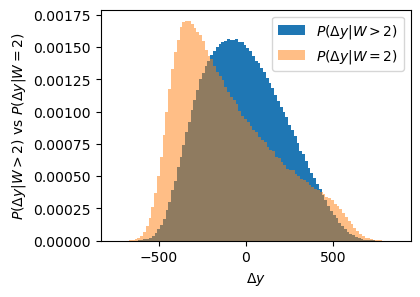

In [11]:
dy_eval = np.arange(np.min(dict_cond_delta_y_more_than_two), 
                    np.max(dict_cond_delta_y_more_than_two), 1)
plt.figure(figsize=(4,3))
plt.hist(dict_cond_delta_y_more_than_two, bins=100, density=True,
         label='$P(\Delta y | W>2)$', alpha=1)
plt.hist(dict_cond_delta_y_equal_two, bins=100, density=True,
         label='$P(\Delta y | W=2)$', alpha=0.5)

plt.ylabel(r'$P(\Delta y | W>2)$ vs $P(\Delta y | W=2)$')
plt.xlabel(r'$\Delta y$')
plt.legend()
plt.savefig("exact_P_dy_ge2sw_2-state.png",
            format="png", bbox_inches="tight", dpi=1200)
plt.show()